T12: 1hr @ 0.5kHz vs T13: 0.5hr @ 1kHz. Both 0.75 Er and 1.5 Er targets.

In [1]:
import numpy as np
import glob as gb
import os
import matplotlib.pyplot as plt
import photonics.fluorescence as fl
from tabulate import tabulate

%matplotlib notebook

In [2]:
save = False

In [3]:
def getfilename(file):
    # Get name from file
    fname = os.path.basename(file)
    fname = os.path.splitext(fname)[0]
    return fname

def getsampleid(file):
    name = getfilename(file)
    sampleno = name.split('_')[0]
    return sampleno

# Spectrum

In [4]:
files = gb.glob('./Spectrum/*.txt')
files = sorted(files, key=lambda x: getsampleid(x)[2:])

# Select only T12 and T13
files = [x for x in files if '12' in x or '13' in x]
files

['./Spectrum\\T12.txt', './Spectrum\\T13.txt']

<IPython.core.display.Javascript object>


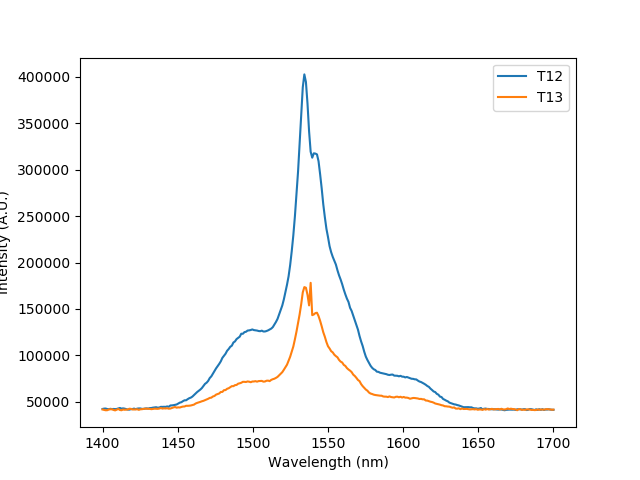

Ratio of maximum intensities: 2.261


In [5]:
norm = False

fig = plt.figure()
ax = fig.add_subplot(111)

imax = []
for f in files:
    # Load data
    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))
    x = data[:,0]
    y = data[:,1]
    imax.append(max(y))

    if norm:
        y = fl.normalise(y)
    
    ax.plot(x, y, label=getsampleid(f))

    plt.legend()
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (A.U.)')
    
if save:
    if norm:
        plt.savefig('./spectrum_raw')
    else:
        plt.savefig('./spectrum_normalised')
        
print('Ratio of maximum intensities: {:.3f}'.format(imax[0]/imax[1]))

# Lifetime

In [6]:
# select files to analyse
files = gb.glob('./Lifetime/secondAttempt/*.txt')

# Select only T12 and T13
files = [x for x in files if '12' in x or '13' in x]
files

['./Lifetime/secondAttempt\\t12_CanolaOil.txt',
 './Lifetime/secondAttempt\\t12_air.txt',
 './Lifetime/secondAttempt\\t13_CanolaOil.txt',
 './Lifetime/secondAttempt\\t13_air.txt']

In [7]:
# Select the required pump
pump = 1
lamp_delay = 0.1

### Single Plot

A             tau        C              Chisq
------------  ---------  -----------  -------
2772.20±3.96  8.01±0.02  691.83±0.67    1.193


<IPython.core.display.Javascript object>


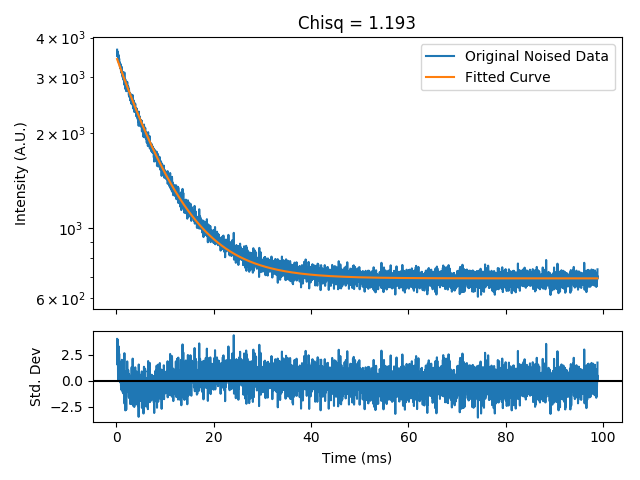

In [8]:
f = files[0]
data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
x = data[:,0]/1E6  # Convert time from us to ms
y = data[:,1]

x = fl.shift_time(x, length=pump+lamp_delay)
x, y = fl.reject_time(x, y, reject_start=0.1, reject_end=0)

popt, perr, chisq = fl.fit_decay(x, y)
fig = fl.plot_decay(x, y, fl.decay_fn, popt)

## Together in air

<IPython.core.display.Javascript object>


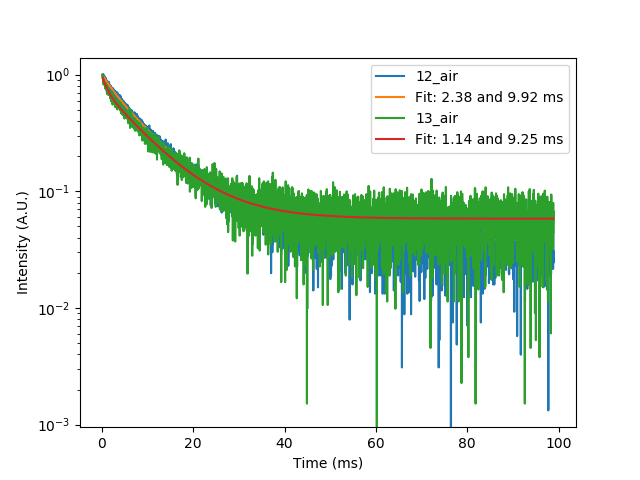

A_1        tau_1      A_2        tau_2      C            Chisq
---------  ---------  ---------  ---------  ---------  -------
0.16±0.01  2.38±0.16  0.81±0.01  9.92±0.07  0.04±0.00        0
A_1        tau_1      A_2        tau_2      C            Chisq
---------  ---------  ---------  ---------  ---------  -------
0.22±0.01  1.14±0.09  0.70±0.01  9.25±0.08  0.06±0.00        0


In [11]:
# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)

##############
# T12
sample = '12_air'
f =  [x for x in files if sample in x]
data = np.genfromtxt(fname=f[0], delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
x = data[:,0]/1E6  # Convert time from us to ms
y = data[:,1]

x = fl.shift_time(x, length=pump+lamp_delay)
x, y = fl.reject_time(x, y, reject_start=0.1, reject_end=0)
y = fl.normalise(y, ref='start')

# Plot raw data
ax.plot(x, y, label=sample)

# Fit and plot
popt, perr, chisq = fl.fit_decay2(x, y)
ax.plot(x, fl.decay_fn2(x, *popt), label='Fit: {:.2f} and {:.2f} ms'.format(popt[1], popt[3]))

############
# T13
sample = '13_air'
f =  [x for x in files if sample in x]

data = np.genfromtxt(fname=f[0], delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
x = data[:,0]/1E6  # Convert time from us to ms
y = data[:,1]

x = fl.shift_time(x, length=pump+lamp_delay)
x, y = fl.reject_time(x, y, reject_start=0.1, reject_end=0)
y = fl.normalise(y, ref='start')

# Plot raw data
ax.plot(x, y, label=sample)

# Fit and plot
popt, perr, chisq = fl.fit_decay2(x, y)
ax.plot(x, fl.decay_fn2(x, *popt), label='Fit: {:.2f} and {:.2f} ms'.format(popt[1], popt[3]))

ax.set_yscale('log')
# plt.xlim(0, 100)
# plt.ylim(0.1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.legend()

if save:
    plt.savefig('./lifetime_both')

<IPython.core.display.Javascript object>


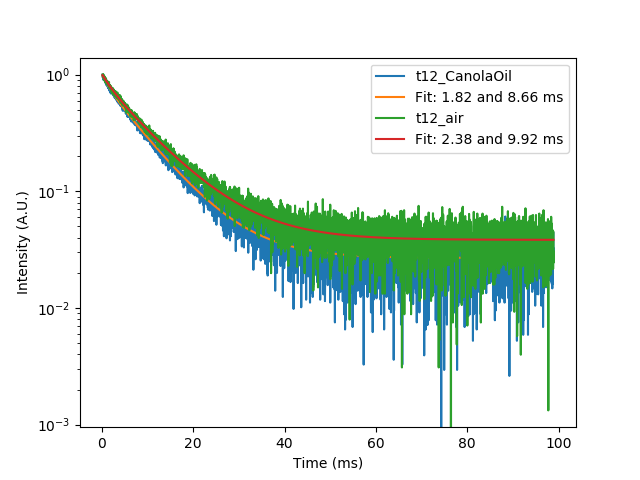

A_1        tau_1      A_2        tau_2      C            Chisq
---------  ---------  ---------  ---------  ---------  -------
0.14±0.01  1.82±0.12  0.83±0.01  8.66±0.04  0.03±0.00        0
1.82425817135
A_1        tau_1      A_2        tau_2      C            Chisq
---------  ---------  ---------  ---------  ---------  -------
0.16±0.01  2.38±0.16  0.81±0.01  9.92±0.07  0.04±0.00        0
2.38041126547


In [12]:
sample = '12' # '12' or '13', optional '_air'

fig = plt.figure()
ax = fig.add_subplot(111)

for f in [x for x in files if sample in x]:

    data = np.genfromtxt(fname=f, delimiter=',', dtype=float, skip_header=10, usecols=(0,1))
    x = data[:,0]/1E6  # Convert time from us to ms
    y = data[:,1]

    x = fl.shift_time(x, length=pump+lamp_delay)
    x, y = fl.reject_time(x, y, reject_start=0.1, reject_end=0)
    y = fl.normalise(y, ref='start', noise=True)
    
    # Plot raw data
    ax.plot(x, y, label=getfilename(f))

    # Fit and plot
    popt, perr, chisq = fl.fit_decay2(x, y)
    ax.plot(x, fl.decay_fn2(x, *popt), label='Fit: {:.2f} and {:.2f} ms'.format(popt[1], popt[3]))
    print(popt[1])

ax.set_yscale('log')
plt.xlabel('Time (ms)')
plt.ylabel('Intensity (A.U.)')
plt.legend()

if save:
    plt.savefig('./lifetime_' + sample)

# Prism Coupler Data

| Sample | n      | d      |
|--------|--------|--------|
|   T12  | 1.4914 | 0.5659 |
| T13    | 1.6235 | 0.3379 |

# Purcell Factor

Comparing air and covered in cassia oil. Note only T13 supports waveguiding.

T12 - 1.096184

T13 - 1.152419 (WG) or 1.268119 (no WG)

Single exp. fit:

| Chip | tau_air    | Chi   | tau_canola | Chi   | ratio  |
|------|------------|-------|------------|-------|--------|
| T12  | 8.93509534 | 1.152 | 7.97581521 | 1.213 | 1.1202 |
| T13  | 8.09503612 | 1.162 | 7.17175881 | 1.208 | 1.1287 |

Double exp. fit:

| Sample | tau^1_air | tau^2_air | Chi   | tau^1_canola | tau^2_canola | Chi   | Ratio tau^1 | Ratio tau^2 |
|--------|-----------|-----------|-------|--------------|--------------|-------|-------------|-------------|
| T12    | 2.208     | 9.873     | 1.018 | 1.732        | 8.641        | 1.056 | 1.275       | 1.143       |
| T13    | 0.734     | 9.048     | 1.008 | 0.886        | 8.127        | 1.067 | 0.828       | 1.113       |

In [5]:
from IPython.display import IFrame
IFrame("./purcell_factor_indivd_T12.png", width=900, height=500)

In [6]:
IFrame("./purcell_factor_indivd_T13.png", width=900, height=500)

# Quantum Efficiency

In [7]:
def qe(tau1, tau2, beta, chip):
    matrix = np.array([[1, 1], [beta, 1]])

    # Invert matrix
    inv = np.linalg.inv(matrix)

    rhs = 1e3*np.array([[1/tau1], [1/tau2]])

    # Solve radiative and non-radiative decay rates
    lhs = inv @ rhs
    rad = lhs[0][0]
    nrad = lhs[1][0]
    q = rad / (rad + nrad)
    
    table = [chip, rad, nrad, 1e3/rad, 1e3/nrad, q*100]
    
    return table

In [8]:
headers = ["Chip", "gamma_rad (/s)", "gamma_nrad (/s)", "tau_rad (ms)", "tau_nrad (ms)", "QE (\%)"]

## T12

In [9]:
beta = 1.096184  # Theoretical SE ratio (Gamma_rad: 1/2)

# Er lifetime
chip = "T12_long"
tau1 = 9.873
tau2 = 8.641

table1 = qe(tau1, tau2, beta, chip)

# Yb lifetime
chip = "T12_short"
tau1 = 2.208
tau2 = 1.732

table2 = qe(tau1, tau2, beta, chip)
print(tabulate([table1, table2], headers=headers))

Chip         gamma_rad (/s)    gamma_nrad (/s)    tau_rad (ms)    tau_nrad (ms)    QE (\%)
---------  ----------------  -----------------  --------------  ---------------  ---------
T12_long            150.139           -48.8531        6.66048         -20.4695     148.233
T12_short          1294.07           -841.17          0.772757         -1.18882    285.73


## T13
### Waveguiding

In [10]:
beta = 1.152419  # 1.152419 (WG) or 1.268119 (no WG)

# Er lifetime
chip = "T13_long"
tau1 = 9.048
tau2 = 8.127

table1 = qe(tau1, tau2, beta, chip)

# Yb lifetime
chip = "T13_short"
tau1 = 0.734
tau2 = 0.886

table2 = qe(tau1, tau2, beta, chip)
print(tabulate([table1, table2], headers=headers))

Chip         gamma_rad (/s)    gamma_nrad (/s)    tau_rad (ms)    tau_nrad (ms)    QE (\%)
---------  ----------------  -----------------  --------------  ---------------  ---------
T13_long            82.1746             28.347       12.1692           35.277      74.3516
T13_short        -1533.47             2895.87        -0.652117          0.34532  -112.557


### No Waveguiding

In [13]:
beta = 1.268119  # 1.152419 (WG) or 1.268119 (no WG)

# Er lifetime
chip = "T13_long"
tau1 = 9.048
tau2 = 8.127

table1 = qe(tau1, tau2, beta, chip)

# Yb lifetime
chip = "T13_short"
tau1 = 0.734
tau2 = 0.886

table2 = qe(tau1, tau2, beta, chip)
print(tabulate([table1, table2], headers=headers))

Chip         gamma_rad (/s)    gamma_nrad (/s)    tau_rad (ms)    tau_nrad (ms)    QE (\%)
---------  ----------------  -----------------  --------------  ---------------  ---------
T13_long            46.7142            63.8074        21.4068           15.6722    42.267
T13_short         -871.738           2234.14          -1.14713           0.4476   -63.9856
